# How to use the `abscal` module of `hera_cal`
<br>
Jan. 2018
<br>
Nick Kern
<br>
nkern@berkeley.edu

---

In this tutorial, we show you one way you can use the absolute calibration capabilities of `hera_cal` to phase and scale data to an absolute reference. We use example data from HERA-47 observation, having extracted out a smaller sub-array from the data.

We do this both on data that has already had `omnical` calibration applied as well as on raw data.

In [29]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import sys
from pyuvdata import UVData, UVCal
import hera_cal as hc
from hera_cal.data import DATA_PATH
from collections import OrderedDict as odict
from pyuvdata import utils as uvutils
import copy
import uvtools as uvt

# Table of Contents

1. [Absolute Calibration of omnical'd data using constrained bandpass solvers](#Absolute-Calibration-of-omnical'd-data-using-constrained-bandpass-solvers)

1. [Absolute Calibration of raw data using general bandpass solvers](#Absolute-Calibration-of-raw-data-using-general-bandpass0-solvers)

# Absolute Calibration of `omnical`'d data using constrained bandpass solvers

We start with data that has already been redundantly calibrated through `omnical`. We then select a model from a different night that has already been absolutely calibrated (using CASA and point source models) that lines up in LST with our data. We then use the ***constrained bandpass*** solvers in `hera_cal.abscal` to solve for the degenerate degrees of freedom missing in the `omnical` solution.

These constrained bandpass solvers are `abs_amp_lincal`, which solves for a single amplitude across all antennas that sets the flux scale, and `TT_phs_logcal`, which solves for the Tip-Tilt of the array and the overall phase scalar of the array.

In [2]:
# specify model file and load into UVData, load into dictionary
model_fname1 = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA")
model_fname2 = os.path.join(DATA_PATH, "zen.2458042.13298.xx.HH.uvXA")
uvm = UVData()
uvm.read_miriad(model_fname1)
uvm2 = UVData()
uvm2.read_miriad(model_fname2)
uvm += uvm2
model_freqs = np.unique(uvm.freq_array)
model_times = np.unique(uvm.lst_array)
model, mflags = hc.abscal.UVData2AbsCalDict(uvm)

# specify data file and load into UVData, load into dictionary
data_fname = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
uvd = UVData()
uvd.read_miriad(data_fname)
data_freqs = np.unique(uvd.freq_array)
data_times = np.unique(uvd.lst_array)
data, dflags = hc.abscal.UVData2AbsCalDict(uvd)

# make wgts
wgts = copy.deepcopy(dflags)
for k in wgts.keys():
    wgts[k] = (~wgts[k]).astype(np.float)

# get antenna positions and make baseline directory
antpos, ants = uvd.get_ENU_antpos(pick_data_ants=True, center=True)
antloc = copy.copy(antpos)
antpos = odict(zip(ants, antpos))
bls = odict([(x, antpos[x[1]] - antpos[x[0]]) for x in model.keys()])

(-30, 30)

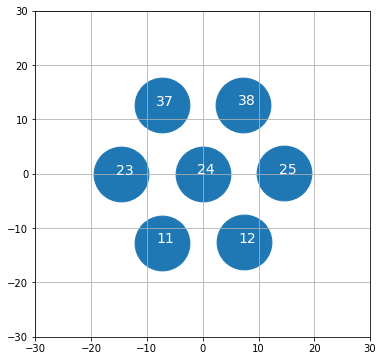

In [3]:
# plot sub-array HERA layout
plt.figure(figsize=(6,6))
plt.grid()
plt.scatter(antloc[:, 0], antloc[:, 1], s=3000)
_ = [plt.text(antloc[i, 0]-1, antloc[i, 1], str(ants[i]), fontsize=14, color='w') for i in range(len(ants))]
plt.xlim(-30, 30)
plt.ylim(-30, 30)

## interpolate model onto time & freq axes of data

In [4]:
model, interp_flags = hc.abscal.interp2d_vis(model, model_times, model_freqs, data_times, data_freqs)

## plot model and data

divide by zero encountered in log10


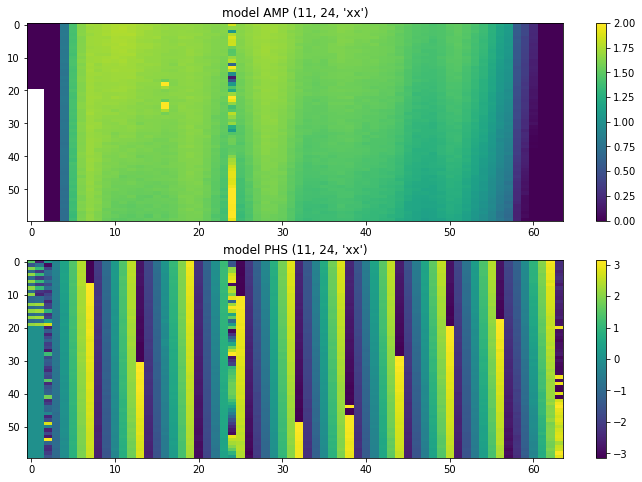

In [5]:
# plot model
bl = (11, 24, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plt.sca(axes[0])
uvt.plot.waterfall(model[bl], mode='log', mx=2, drng=2)
plt.colorbar()
plt.title('model AMP {}'.format(bl))
plt.sca(axes[1])
uvt.plot.waterfall(model[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('model PHS {}'.format(bl))

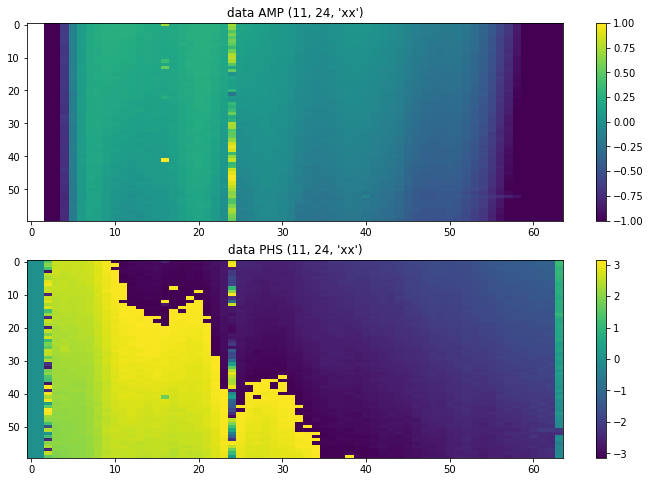

In [6]:
# plot data
bl = (11, 24, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plt.sca(axes[0])
uvt.plot.waterfall(data[bl], mode='log', mx=1, drng=2)
plt.colorbar()
plt.title('data AMP {}'.format(bl))
plt.sca(axes[1])
uvt.plot.waterfall(data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data PHS {}'.format(bl))

## Instantiate `AbsCal` object

In [7]:
# instantiate class
AC = hc.abscal.AbsCal(model, data, antpos=antpos, wgts=wgts, freqs=data_freqs)

## run delay solver and inspect gains

In [8]:
AC.delay_lincal(kernel=(1, 5))

divide by zero encountered in divide
invalid value encountered in divide


...running linsolve
...finished linsolve


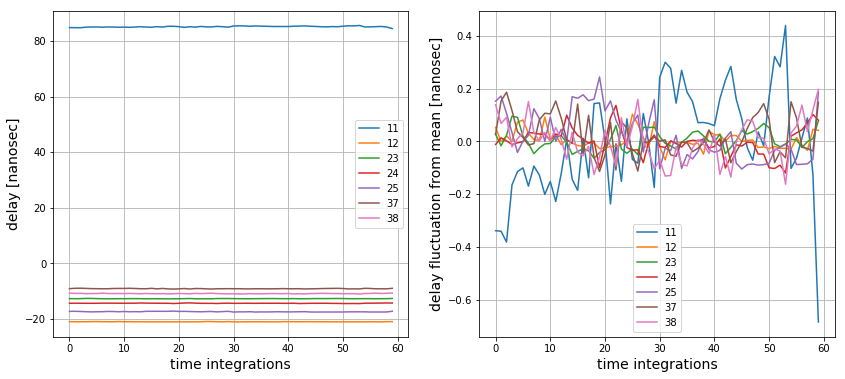

In [9]:
# inspect delays
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
ax.grid()
dlys = AC.get_ant_dly[:, :, 0].T * 1e9
pl = ax.plot(dlys)
ax.legend(pl, AC.ants)
ax.set_xlabel('time integrations', fontsize=14)
ax.set_ylabel('delay [nanosec]', fontsize=14)

ax = axes[1]
ax.grid()
mean_dly = np.median(dlys, axis=0)
pl = ax.plot(dlys - mean_dly)
ax.legend(pl, AC.ants)
ax.set_xlabel('time integrations', fontsize=14)
ax.set_ylabel('delay fluctuation from mean [nanosec]', fontsize=14)

In [11]:
# construct gains
delay_gains = odict(zip(AC.ants, AC.get_ant_dly_gain))

# apply to data
delay_corr_data = hc.abscal.apply_gains(AC.data, delay_gains)

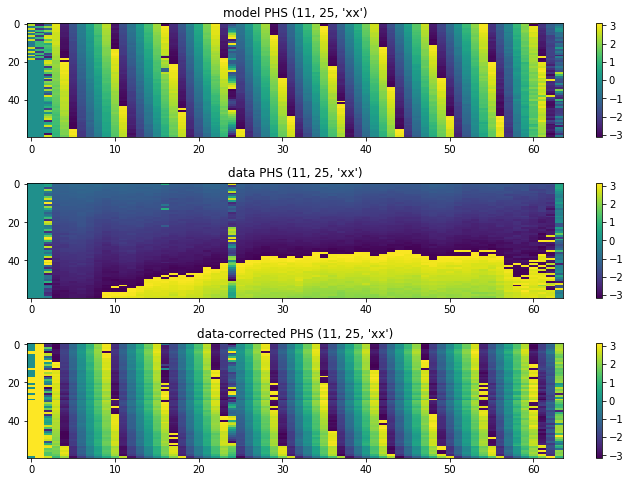

In [14]:
# inspect results data
ants = AC.ants.tolist()
bl = (11, 25, 'xx')
ak1, ak2 = ants.index(bl[0]), ants.index(bl[1])
fig, axes = plt.subplots(3, 1, figsize=(12, 8))
fig.subplots_adjust(hspace=0.4)

plt.sca(axes[0])
uvt.plot.waterfall(model[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('model PHS {}'.format(bl))

plt.sca(axes[1])
uvt.plot.waterfall(data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data PHS {}'.format(bl))

plt.sca(axes[2])
uvt.plot.waterfall(corr_data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data-corrected PHS {}'.format(bl))

## reinstantiate `AbsCal` with delay-corrected data

In [15]:
# instantiate class
DAC = hc.abscal.AbsCal(model, delay_corr_data, antpos=antpos, wgts=wgts, freqs=data_freqs)

## run absolute amplitude solver

In [16]:
# run amp linsolve
DAC.abs_amp_lincal()

...configuring linsolve data for abs_amp_lincal
...running linsolve


divide by zero encountered in divide
invalid value encountered in divide


...finished linsolve


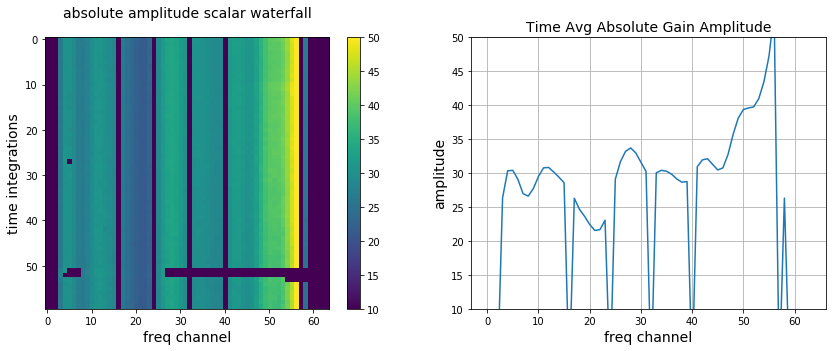

In [17]:
# inspect absolute scalar results
# plot gain amp
fig, axes = plt.subplots(1, 2, figsize=(14,5))

ax = axes[0]
cax = ax.matshow(DAC.get_abs_amp, aspect='auto', vmax=50, vmin=10)
fig.colorbar(cax, ax=ax)
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('freq channel', fontsize=14)
ax.set_ylabel('time integrations', fontsize=14)
ax.set_title('absolute amplitude scalar waterfall', fontsize=14)

ax = axes[1]
ax.plot(np.median(DAC.get_abs_amp, axis=0))
ax.grid()
ax.set_xlabel('freq channel', fontsize=14)
ax.set_title('Time Avg Absolute Gain Amplitude', fontsize=14)
ax.set_ylim(10, 50)
ax.set_ylabel('amplitude', fontsize=14)

## run tip-tilt phase solver

In [18]:
# run phs linsolve
DAC.TT_phs_logcal(zero_psi=False)

...configuring linsolve data for TT_phs_logcal
...running linsolve


divide by zero encountered in divide
invalid value encountered in divide


...finished linsolve


### plot overall phase

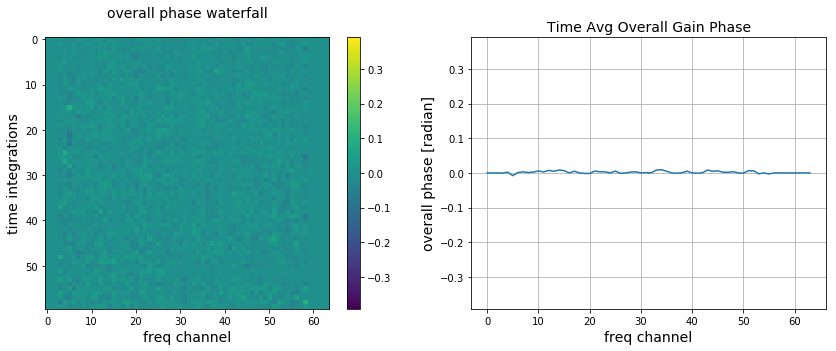

In [19]:
# plot psi
fig, axes = plt.subplots(1, 2, figsize=(14,5))

ax = axes[0]
cax = ax.matshow(DAC.get_abs_psi, aspect='auto', vmin=-np.pi/8, vmax=np.pi/8)
fig.colorbar(cax, ax=ax)
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('freq channel', fontsize=14)
ax.set_ylabel('time integrations', fontsize=14)
ax.set_title('overall phase waterfall', fontsize=14)

ax = axes[1]
ax.plot(np.median(DAC.get_abs_psi, axis=0))
ax.grid()
ax.set_xlabel('freq channel', fontsize=14)
ax.set_title('Time Avg Overall Gain Phase', fontsize=14)
ax.set_ylim(-np.pi/8, np.pi/8)
ax.set_ylabel('overall phase [radian]', fontsize=14)

### inspect tip-tilt phase

(-0.1, 0.1)

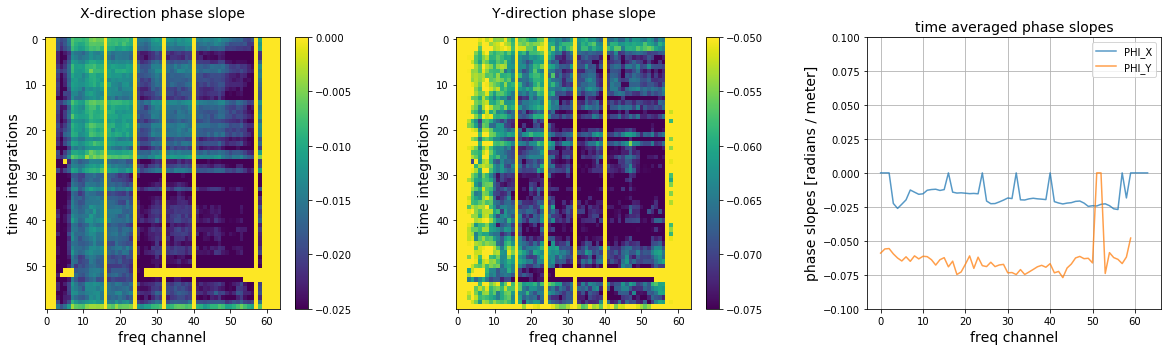

In [20]:
# plot gain phi
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.subplots_adjust(wspace=0.4)

ax = axes[0]
cax = ax.matshow(DAC.get_TT_Phi[0], aspect='auto', vmin=-.025, vmax=0)
fig.colorbar(cax, ax=ax)
ax.set_title('PHI_X')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('freq channel', fontsize=14)
ax.set_ylabel('time integrations', fontsize=14)
ax.set_title('X-direction phase slope', fontsize=14)

ax = axes[1]
cax = ax.matshow(DAC.get_TT_Phi[1], aspect='auto', vmin=-.075, vmax=-.05)
fig.colorbar(cax, ax=ax)
ax.set_title('PHI_Y')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('freq channel', fontsize=14)
ax.set_ylabel('time integrations', fontsize=14)
ax.set_title('Y-direction phase slope', fontsize=14)

ax = axes[2]
p0, = ax.plot(np.nanmedian(DAC.get_TT_Phi[0, :, :], axis=0), alpha=0.75)
p1, = ax.plot(np.nanmedian(DAC.get_TT_Phi[1, :, :], axis=1), alpha=0.75)
ax.grid()
ax.set_xlabel('freq channel', fontsize=14)
ax.set_title('time averaged phase slopes', fontsize=14)
ax.set_ylabel('phase slopes [radians / meter]', fontsize=14)
ax.legend([p0,p1], ["PHI_X", "PHI_Y"])
ax.set_ylim(-.1, .1)

In [24]:
# form gains
abs_gains = odict(zip(DAC.ants, DAC.get_abs_psi_gain * DAC.get_abs_amp_gain))

# apply to data
abs_corr_data = hc.abscal.apply_gains(DAC.data, abs_gains)

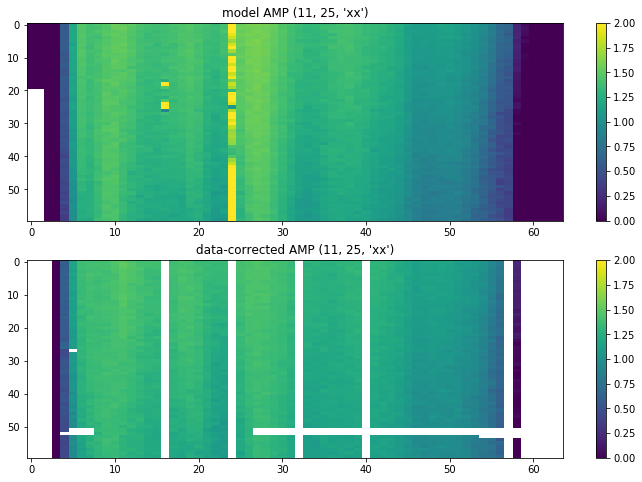

In [25]:
# plot model and data-corrected amplitude
bl = (11, 25, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plt.sca(axes[0])
uvt.plot.waterfall(model[bl], mode='log', mx=2, drng=2)
plt.colorbar()
plt.title('model AMP {}'.format(bl))

plt.sca(axes[1])
uvt.plot.waterfall(abs_corr_data[bl], mode='log', mx=2, drng=2)
plt.colorbar()
plt.title('data-corrected AMP {}'.format(bl))

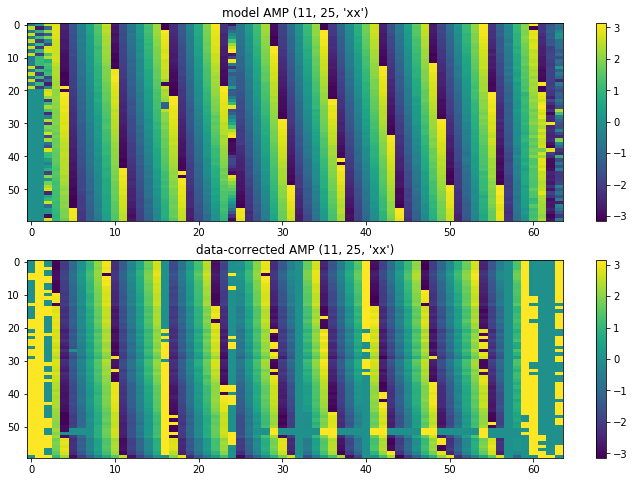

In [27]:
# plot model and data-corrected phase
bl = (11, 25, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plt.sca(axes[0])
uvt.plot.waterfall(model[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('model AMP {}'.format(bl))

plt.sca(axes[1])
uvt.plot.waterfall(abs_corr_data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data-corrected AMP {}'.format(bl))

# Absolute Calibration of raw data using general bandpass solvers

This is essentially identical to our procedure before, but this time we start with raw data (rather than `omnical`'d data), and also we use the general bandpass solvers `amp_logcal` and `phs_logcal`, rather than the constrained bandpass solvers.

In [31]:
# specify model file and load into UVData, load into dictionary
model_fname1 = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA")
model_fname2 = os.path.join(DATA_PATH, "zen.2458042.13298.xx.HH.uvXA")
uvm = UVData()
uvm.read_miriad(model_fname1)
uvm2 = UVData()
uvm2.read_miriad(model_fname2)
uvm += uvm2
model_freqs = np.unique(uvm.freq_array)
model_times = np.unique(uvm.lst_array)
model, mflags = hc.abscal.UVData2AbsCalDict(uvm)

# specify data file and load into UVData, load into dictionary
data_fname = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvA")
uvd = UVData()
uvd.read_miriad(data_fname)
data_freqs = np.unique(uvd.freq_array)
data_times = np.unique(uvd.lst_array)
data, dflags = hc.abscal.UVData2AbsCalDict(uvd)

# make wgts
wgts = copy.deepcopy(dflags)
for k in wgts.keys():
    wgts[k] = (~wgts[k]).astype(np.float)

# get antenna positions and make baseline directory
antpos, ants = uvd.get_ENU_antpos(pick_data_ants=True, center=True)
antloc = copy.copy(antpos)
antpos = odict(zip(ants, antpos))
bls = odict([(x, antpos[x[1]] - antpos[x[0]]) for x in model.keys()])

In [32]:
model, interp_flags = hc.abscal.interp2d_vis(model, model_times, model_freqs, data_times, data_freqs)

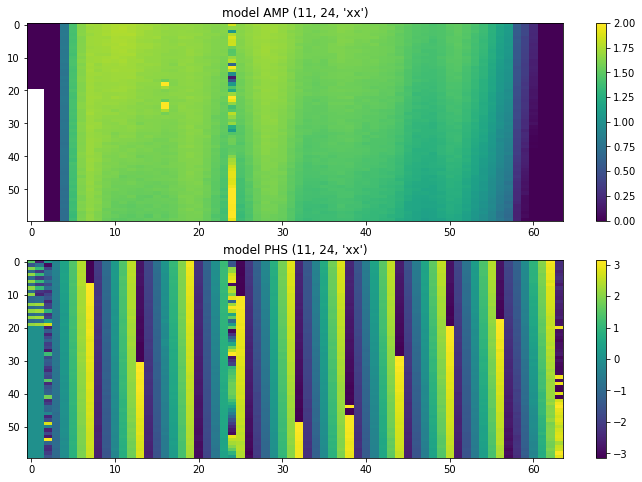

In [33]:
# plot model
bl = (11, 24, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plt.sca(axes[0])
uvt.plot.waterfall(model[bl], mode='log', mx=2, drng=2)
plt.colorbar()
plt.title('model AMP {}'.format(bl))
plt.sca(axes[1])
uvt.plot.waterfall(model[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('model PHS {}'.format(bl))

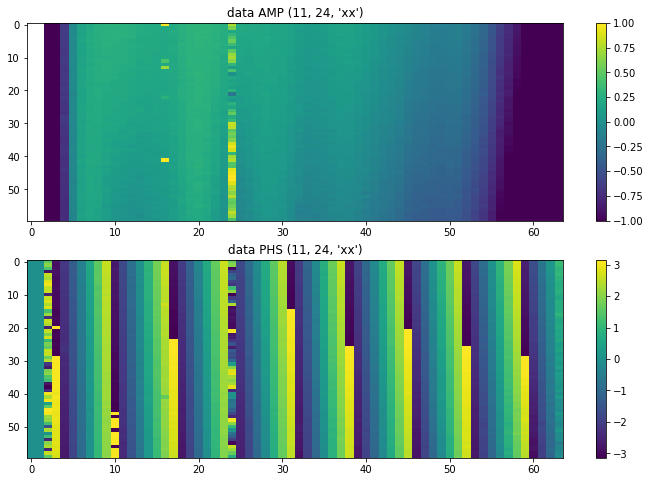

In [34]:
# plot data
bl = (11, 24, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plt.sca(axes[0])
uvt.plot.waterfall(data[bl], mode='log', mx=1, drng=2)
plt.colorbar()
plt.title('data AMP {}'.format(bl))
plt.sca(axes[1])
uvt.plot.waterfall(data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data PHS {}'.format(bl))

In [35]:
# instantiate class
AC = hc.abscal.AbsCal(model, data, antpos=antpos, wgts=wgts, freqs=data_freqs)

In [36]:
AC.delay_lincal(kernel=(1, 5))

...running linsolve
...finished linsolve


In [37]:
# construct gains
delay_gains = odict(zip(AC.ants, AC.get_ant_dly_gain))

# apply to data
delay_corr_data = hc.abscal.apply_gains(AC.data, delay_gains)

In [38]:
# instantiate class
DAC = hc.abscal.AbsCal(model, delay_corr_data, antpos=antpos, wgts=wgts, freqs=data_freqs)

In [39]:
# run amp logcal
DAC.amp_logcal()

...configuring linsolve data for amp_logcal
...running linsolve


divide by zero encountered in divide
invalid value encountered in divide


...finished linsolve


In [40]:
# run phs linsolve
DAC.phs_logcal()

...configuring linsolve data for phs_logcal
...running linsolve


divide by zero encountered in divide
invalid value encountered in divide


...finished linsolve


In [41]:
# form gains
abs_gains = odict(zip(DAC.ants, DAC.get_ant_eta_gain * DAC.get_ant_phi_gain))

# apply to data
abs_corr_data = hc.abscal.apply_gains(DAC.data, abs_gains)

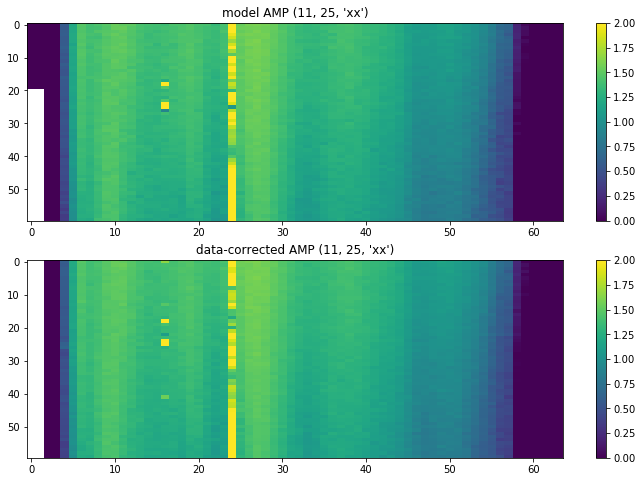

In [42]:
# plot model and data-corrected amplitude
bl = (11, 25, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plt.sca(axes[0])
uvt.plot.waterfall(model[bl], mode='log', mx=2, drng=2)
plt.colorbar()
plt.title('model AMP {}'.format(bl))

plt.sca(axes[1])
uvt.plot.waterfall(abs_corr_data[bl], mode='log', mx=2, drng=2)
plt.colorbar()
plt.title('data-corrected AMP {}'.format(bl))

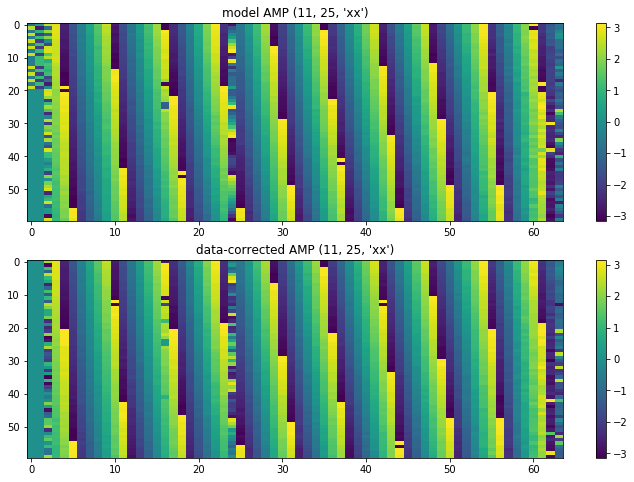

In [43]:
# plot model and data-corrected phase
bl = (11, 25, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plt.sca(axes[0])
uvt.plot.waterfall(model[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('model AMP {}'.format(bl))

plt.sca(axes[1])
uvt.plot.waterfall(abs_corr_data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data-corrected AMP {}'.format(bl))